# Dataset: Software

## Metadata:
1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
2. asin - ID of the product, e.g. 0000013714
3. reviewerName - name of the reviewer
4. vote - helpful votes of the review
5. style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"
6. reviewText - text of the review
7. overall - rating of the product
8. summary - summary of the review
9. unixReviewTime - time of the review (unix time)
10. reviewTime - time of the review (raw)
11. image - images that users post after they have received the product

# 0. Prerequisite

In [2]:
!pip install TextBlob
!pip install nlpaug
!pip install contractions
!pip install wordcloud
!pip install sentence-transformers
!pip install scikit-surprise

     ---------------------------------------- 0.0/772.0 kB ? eta -:--:--
     ------------------ ------------------- 368.6/772.0 kB 7.8 MB/s eta 0:00:01
     ----------------------------- -------- 593.9/772.0 kB 7.5 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for scikit-surprise
Failed to build scikit-surprise


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [101 lines of output]
  C:\Users\sksfm\AppData\Local\Temp\pip-install-8ljlwqml\scikit-surprise_960f8496b7ff4203ade766e8c1e2f41f\setup.py:65: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!
    dist.Distribution().fetch_build_eggs(["numpy>=1.17.3"])
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-cpython-311\surprise
  copying surprise\bu

# 1. Load Libraries

## 1.1 Preprocessing Library

In [1]:
import requests
import shutil
import os
import re
import html
import unicodedata
from textblob import TextBlob
import string
import spacy
import contractions

class util:

    def __init__(self):
        pass

    def download_data(url, target_path):
      if not os.path.exists(target_path):
        response = requests.get(url, stream=True)
        if response.status_code == 200:
          directory = os.path.dirname(target_path)
          if not os.path.exists(directory):
              os.makedirs(directory)
          with open(target_path, "wb") as f:
              shutil.copyfileobj(response.raw, f)
        else:
            print("Failed to download the file")
      else:
          print("File already exists locally.")

    def read_file_to_df(file_path):
        import pandas as pd

        ext = file_path.split('.')[-1]
        if ext == 'json':
            return pd.read_json(file_path, lines=True)
        elif ext == 'gz':
            import gzip
            with gzip.open(file_path, 'rb') as file:
                return pd.read_json(file, lines=True)
        elif ext == 'csv':
            return pd.read_csv(file_path)
        else:
            return None

class preprocessing():
    nlp = spacy.load('en_core_web_sm')
    stop_words = nlp.Defaults.stop_words - {'against', 'although', 'although', 'cannot', 'except', 'however', 'least', 'less', 'n‘t', 'n’t', 'neither', 'never', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'nowhere', "n't", 'somehow', 'without', 'yet'}

    def correct_spelling(text):
        return str(TextBlob(text).correct())

    def fix_contractions(text):
        return contractions.fix(text)

    def remove_spaces(text):
        text = ' '.join(text.split())  # remove extra spaces
        return text

    def remove_punctuations(text):
        pattern = re.compile('[%s]' % re.escape(string.punctuation))
        text = pattern.sub(' ', text) # remove punctuation
        return text

    def remove_hyperlinks(text):
        pattern = r"(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?" # remove hyperlinks
        text = text.replace(pattern, ' ')
        return text

    def remove_html_tags(text):
        pattern = re.compile(r'<.*?>') # remove html tags
        text = pattern.sub(' ',text)
        return text

    def replace_emoji(text): # seems to make no difference
        emoji_dict = {'://)':'embarrassed', '://3':'embarrassed', ':-))':'happy', ':\'‑)':'happy', ':-||':'sad', ':\'‑(':'sad',
                      '>:(':'angry', '>:[':'angry', ':-/':'annoyed', ':‑.':'annoyed', ':o)':'happy', ':c)':'happy', ':^)':'happy',
                      ':‑)':'happy', ':-]':'happy', ':->':'happy', '8-)':'happy', ':-}':'happy', ':‑D':'happy', '8‑D':'happy',
                      'B^D':'happy', 'x‑D':'happy', 'X‑D':'happy', ':\')':'happy', ':"D':'happy', ':-3':'happy', ':-*':'happy',
                      ';‑)':'happy', '*-)':'happy', ';‑]':'happy', ';^)':'happy', ':‑,':'happy', ':‑P':'happy', 'X‑P':'happy',
                      'x‑p':'happy', ':‑p':'happy', ':‑Þ':'happy', ':‑þ':'happy', ':‑b':'happy', '>:P':'happy', ':‑(':'sad',
                      ':‑c':'sad', ':‑<':'sad', ':‑[':'sad', ':\'(':'sad', ':=(':'sad', '>:\\':'undecided', '>:/':'undecided',
                      ':\\':'annoyed', '=/':'annoyed', '=\\':'annoyed', ':L':'annoyed', '=L':'annoyed', ':S':'annoyed', ':/':'annoyed',
                      ':$':'Embarrassed', '=]':'happy', '=)':'happy', ':)':'happy', ':]':'happy', ':>':'happy', '8)':'happy', ':}':'happy', '=D':'happy',
                      '=3':'happy', 'c:':'happy', 'C:':'happy', ':D':'happy', '8D':'happy', 'xD':'happy', 'XD':'happy', ':3':'happy', '=3':'happy',
                      'x3':'happy', 'X3':'happy', ':*':'happy', ':×':'happy', ';D':'happy', ';3':'happy', ';)':'happy', '*)':'happy',
                      ';]':'happy', ';>':'happy', 'd:':'happy', '=p':'happy', ':P':'happy', 'XP':'happy', 'xp':'happy', ':p':'happy',
                      ':Þ':'happy', ':þ':'happy', ':b':'happy', ':(':'sad', ':c':'sad', ':<':'sad', ':[':'sad', ':{':'sad', ':@':'sad',
                      ':(':'sad', ';(':'sad', 'D=':'sad', 'DX':'sad', }
        for emoji, word in emoji_dict.items():
            text = text.replace(emoji, word)
        return text

    def remove_emoji(text):
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def fill_star(text):    # seem to make no difference
        text = re.sub(r"1\s*stars?", 'very negative', text, flags=re.IGNORECASE)
        text = re.sub(r"one\s*stars?", 'very negative', text, flags=re.IGNORECASE)

        text = re.sub(r"2\s*stars?", 'negative', text, flags=re.IGNORECASE)
        text = re.sub(r"two\s*stars?", 'negative', text, flags=re.IGNORECASE)


        text = re.sub(r"3\s*stars?", 'neutral', text, flags=re.IGNORECASE)
        text = re.sub(r"three\s*stars?", 'neutral', text, flags=re.IGNORECASE)

        text = re.sub(r"4\s*stars?", 'positive', text, flags=re.IGNORECASE)
        text = re.sub(r"four\s*stars?", 'positive', text, flags=re.IGNORECASE)

        text = re.sub(r"5\s*stars?", 'very positive', text, flags=re.IGNORECASE)
        text = re.sub(r"five\s*stars?", 'very positive', text, flags=re.IGNORECASE)

        return text

    # https://opensourceconnections.com/blog/2023/01/24/10-reasons-why-you-shouldnt-remove-stop-words/
    def remove_stopwords(text):
        return ' '.join([token.text for token in preprocessing.nlp(text) if not token.text.lower() in preprocessing.stop_words])

    def base_preprocessing(text):
        text = preprocessing.remove_hyperlinks(text)
        text = preprocessing.remove_html_tags(text)
        text = html.unescape(text)  # &amp; -> &
        text = ''.join((c if not unicodedata.category(c).startswith('C') else ' ') for c in text) # remove control characters

        # Replace escape sequences
        text = text.replace(r'\n',' ')  # remove new lines
        text = text.replace(r'\t',' ')  # remove tabs
        text = preprocessing.fill_star(text) # convert star ratings to text
        text = ''.join(filter(lambda x: not x.isdigit(), text))  # remove digits
        text = ' '.join(filter(lambda x: len(x) > 1, text.split()))  # remove single characters

        return text

    def full_preprocessing(text):
        text = preprocessing.base_preprocessing(text)
        text = preprocessing.replace_emoji(text)
        text = preprocessing.remove_punctuations(text)
        text = text.lower()  # convert to lower case
        #text = preprocessing.remove_stopwords(text)
        text = preprocessing.remove_spaces(text)
        return text

    """
    Preprocessing function for vader
    punctuation and lower case were habdled by the vader library
    Sarcasm and Irony, Negation, Context Dependency, Domain-Specific Language, Subjectivity and Ambiguity, Non-Textual Features
    """
    def vader_preprocessing(text):
        text = preprocessing.base_preprocessing(text)
        text = preprocessing.remove_punctuations(text) # for supervised learning
        #text = preprocessing.remove_stopwords(text)
        text = preprocessing.remove_spaces(text)
        return text

    """
    Preprocessing function for textbob
    punctuation and lower case were habdled by the textbob library
    """
    def textblob_preprocessing(text):
        text = preprocessing.base_preprocessing(text)
        #text = preprocessing.replace_emoji(text)
        text = preprocessing.fix_contractions(text)  # fix contractions
        text = preprocessing.remove_punctuations(text) # for supervised learning
        #text = preprocessing.remove_stopwords(text)
        text = preprocessing.remove_spaces(text)
        return text

    def calculate_statistics(col, percentage):

        # Calculate Q1, Q3, and IQR for the 'reviewLength' column
        Q1 = col.quantile(percentage)
        Q3 = col.quantile(1-percentage)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        return upper_bound, lower_bound

    def get_review_clean(df,preprocesser):
        df_new = df.copy()
        df_new['reviewText_clean'] = df['summary'].str.cat(df['reviewText'], sep=' ', na_rep='').str.strip().apply(lambda text: preprocesser(text))
        return df_new

    def remove_outliers(df):
        df_new = df.copy()
        # not verified, no votes, and the review length is less than the lower bound or greater than the upper bound
        # use interquartile range to identify outliers
        (upper_bound, lower_bound) = preprocessing.calculate_statistics(df['reviewText_len'], 0.25)

        print(f'** Quartile range of reviewText length: ({lower_bound} - {upper_bound})')
        criteria = (~df['verified']) & (df['vote'] == 0) & ((df['reviewText_len'] < lower_bound) | (df['reviewText_len'] > upper_bound))
        print(df_new.shape)
        df_new= df_new[~criteria]
        print(df_new.shape)
        return df_new

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def print_statistics(df, model):
  print(f"** {model} Statistics:")
  print(f"** Accuracy: {accuracy_score(df['sentiment'], df[f'sentiment_{model}'])}")
  print(f"** F1 Score: {f1_score(df['sentiment'], df[f'sentiment_{model}'], average='macro')}")
  print(f"** Confusion Matrix:\n{confusion_matrix(df['sentiment'], df[f'sentiment_{model}'], labels=df['sentiment'].unique())}")
  print('\n')


## 1.2 Sentiment analysis library


In [3]:
import nltk
nltk_data_path = "./nltk_data"
nltk_vader_name = 'vader_lexicon'
nltk.download(nltk_vader_name,download_dir=nltk_data_path)
nltk.data.path.append(nltk_data_path)

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

class vader_sentiment_analyser:
    def __init__(self):
        self.analyser = SentimentIntensityAnalyzer()

    def scores_detail(self, text, print=False):
        score = self.analyser.polarity_scores(text)
        if print:
            print("{:-<40} {}".format(text, str(score)))
        # score: {'neg': 0.0, 'neu': 0.349, 'pos': 0.651, 'compound': 0.8016}
        return score
    def scores_avg(self, text):
        score = self.analyser.polarity_scores(text)['compound']
        return score

    def sentiment(self, text):
        score = self.scores_avg(text)
        return ('Positive' if score >=0.05 else ('Negative' if score <= -0.05 else 'Neutral'))


class textblob_sentiment_analyser:
    #pip install textblob
    def __init__(self, text):
        self.text = text
        self.analyser = TextBlob(text)

    def scores_detail(self):
        score = self.analyser.sentiment.polarity
        label = "pos" if score > 0 else "neg" if score < 0 else "neu"
        return {label: score}
    def scores_avg(self):
        score = self.analyser.sentiment.polarity
        return score

    def subjectivity(self):
        return self.analyser.sentiment.subjectivity

    def sentiment(self):
        score = self.scores_avg()
        return ('Positive' if score>0 else ('Negative' if score<0 else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to ./nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Load data

In [4]:
import warnings
warnings.filterwarnings('ignore')

# import libraries
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
full_data_gzip_path = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFiles/Software.json.gz' # full dataset
sample_data_gzip_path = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Software_5.json.gz'  # sample dataset

file_path = './data/Software.json.gz' # change the file path to json/ gz

util.download_data(full_data_gzip_path, file_path)  # download data if not found
df = util.read_file_to_df(file_path)  # read the dataset
df['reviewID'] = df.index  # create a new column for reviewID
df['vote'] = df['vote'].str.replace(',', '').apply(lambda x: 0 if pd.isnull(x) else int(x))  # convert vote to int
df['sentiment'] = df['overall'].apply(lambda x: 'Positive' if x in [4, 5] else ('Neutral' if x == 3 else 'Negative'))
df['reviewText_clean'] = df['summary'].str.cat(df['reviewText'], sep=' ', na_rep='').str.strip().apply(lambda text: preprocessing.full_preprocessing(text))
df['reviewText_len'] = df['reviewText_clean'].apply(lambda x: len(x.split()))


File already exists locally.


# 3. Preprocessing

In [5]:
# Drop duplicated reviews based on the specified subset of columns
# Keep only the first occurrence of each duplicated review, and drop subsequent occurrences
df_processed = df.copy()
df_processed = df_processed.drop_duplicates(subset=['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote'], keep='first', inplace=False) # basic drop duplicated records

# remove outliers
df_processed = preprocessing.remove_outliers(df_processed)

df_processed['reviewText_clean_vader'] = df_processed['summary'].str.cat(df_processed['reviewText'], sep=' ', na_rep='').str.strip().apply(lambda text: preprocessing.vader_preprocessing(text))
df_processed['reviewText_clean_textblob'] = df_processed['summary'].str.cat(df_processed['reviewText'], sep=' ', na_rep='').str.strip().apply(lambda text: preprocessing.textblob_preprocessing(text))


** Quartile range of reviewText length: (-94.5 - 205.5)
(450903, 16)
(443672, 16)


# 3. Supervised learning model Analysis

---


11.	Modeling (Sentiment Analysis) Machine Learning approach: \
a.	Select a subset of the original data minimum 2000 reviews, check point 14 below as you select the subset.\
b.	Carry out data exploration on the subset and pre-processing and justify each step of preprocessing.\
c.	Represent your text using one of the text represtations discussed in the course, make sure to note in your report why you chose that representation.\
d.	Split the data into 70% for training and 30% for testing,—Use stratified splitting based on the rating value field.\
e.	Build two sentiment analysis models using 70% of the data. Choose two of the following Machine Learning algorithms to build and fine tune your models:\
i.	Logistic Regression \
ii.	SVM\
iii.	Naïve Bayes\
iv.	Gradient Boosting\
v.	MLP
12.	Note the results of the training process in your report.
13.	Testing: Test out the two models using the 30% test data note the accuracy, precision, recall, confusion matrix and F1 score in your report.
14.	Design an experiment to compare the test results of the Lexicon model versus the two machine learning models:\
a.	Prepare the data: Here you will need to create a situation where you compare apples to apples, so whatever you used in the Lexicon should be the test data for your machine learing model, this step requires good design.\
b.	Run both models on the same data and compare the results using appropriate matrics.


# 3.1 Prepare dataset

In [6]:
# todo
# select 1000 from each sentiment
df_positive = df_processed[df_processed['sentiment'] == 'Positive'].sample(n=1000, random_state=42)
df_negative = df_processed[df_processed['sentiment'] == 'Negative'].sample(n=1000, random_state=42)
df_neutral = df_processed[df_processed['sentiment'] == 'Neutral'].sample(n=1000, random_state=42) #without neutral performs better
df_combined = pd.concat([df_positive, df_negative, df_neutral])

df_combined['sentiment'].value_counts()


Positive    1000
Negative    1000
Neutral     1000
Name: sentiment, dtype: int64

In [7]:
df_combined['score_vader'] = df_combined['reviewText_clean_vader'].apply(lambda x: vader_sentiment_analyser().scores_avg(x))
df_combined['sentiment_vader'] = df_combined['reviewText_clean_vader'].apply(lambda x: vader_sentiment_analyser().sentiment(x))

df_combined['score_textblob'] = df_combined['reviewText_clean_textblob'].apply(lambda x: textblob_sentiment_analyser(x).scores_avg())
df_combined['sentiment_textblob'] = df_combined['reviewText_clean_textblob'].apply(lambda x: textblob_sentiment_analyser(x).sentiment())


In [8]:
print_statistics(df_combined, 'vader')
print_statistics(df_combined, 'textblob')

** vader Statistics:
** Accuracy: 0.511
** F1 Score: 0.4410378319441439
** Confusion Matrix:
[[931  51  18]
 [419 529  52]
 [695 232  73]]


** textblob Statistics:
** Accuracy: 0.49766666666666665
** F1 Score: 0.4250947684333351
** Confusion Matrix:
[[949  29  22]
 [464 485  51]
 [764 177  59]]




# 3.2 Preprocessing

## 3.2.1 Vader

In [9]:
from sklearn.metrics import balanced_accuracy_score, pair_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit

X = df_combined['reviewText_clean_vader'].reset_index(drop=True)
y = df_combined['sentiment'].reset_index(drop=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train,X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [10]:
#### TfidfVectorizer/ CountVectorizer/ Word2Vec/ Glove/ Bert etc, need to test which is better

#### TfidfVectorizer
word_vectorizer_tfidf = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
                                        analyzer='word',token_pattern=r'\w{1,}',
                                        stop_words='english',
                                        ngram_range=(1, 1), max_features=10000)
word_vectorizer_tfidf.fit(X_train)

# train - test vectorized features
train_word_features_tfidf = word_vectorizer_tfidf.transform(X_train)
test_word_features_tfidf = word_vectorizer_tfidf.transform(X_test)

#### CountVectorizer
vectorizer_count = CountVectorizer()
vectorizer_count.fit(X_train)
train_word_features_count = vectorizer_count.transform(X_train)
test_word_features_count = vectorizer_count.transform(X_test)


In [11]:
#### Word2Vec
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=10000, window=5, min_count=1, workers=4, sg=0):
        """
        vector_size: Dimensionality of the word vectors.
        window: Maximum distance between the current and predicted word within a sentence.
        min_count: Ignores all words with total frequency lower than this.
        workers: Use these many worker threads to train the model (=faster training with multicore machines).
        sg: Training algorithm: 1 for skip-gram; otherwise CBOW.
        """
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.sg = sg
        self.model = None

    def fit(self, X, y=None):
        # Tokenize the text
        tokenized_text = [text.split() for text in X]
        # Train the model
        self.model = Word2Vec(sentences=tokenized_text, vector_size=self.vector_size,
                              window=self.window, min_count=self.min_count,
                              workers=self.workers, sg=self.sg)
        return self

    def transform(self, X, y=None):
        # Tokenize the text
        tokenized_text = [text.split() for text in X]
        # Vectorize sentences using the average of word vectors
        sentence_vectors = []
        for tokens in tokenized_text:
            if tokens:
                word_vectors = [self.model.wv[word] for word in tokens if word in self.model.wv]
                if word_vectors:
                    sentence_vectors.append(np.mean(word_vectors, axis=0))
                else:
                    sentence_vectors.append(np.zeros(self.vector_size))
            else:
                sentence_vectors.append(np.zeros(self.vector_size))
        return np.array(sentence_vectors)


# For CBOW Model
cbow_vectorizer = Word2VecVectorizer(sg=0)  # sg=0 for CBOW
cbow_vectorizer.fit(X_train)
train_features_cbow = cbow_vectorizer.transform(X_train)
test_features_cbow = cbow_vectorizer.transform(X_test)

# For Skip-Gram Model
skipgram_vectorizer = Word2VecVectorizer(sg=1)  # sg=1 for Skip-Gram
skipgram_vectorizer.fit(X_train)
train_features_skipgram = skipgram_vectorizer.transform(X_train)
test_features_skipgram = skipgram_vectorizer.transform(X_test)

In [12]:
### GloVe
def load_glove_model(glove_file_path):
    print("Loading Glove Model")
    glove_model = {}
    with open(glove_file_path, 'r', encoding="utf8") as file:
        for line in file:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_path = './glove.6B.100d.txt'
glove_embeddings = load_glove_model(glove_path)

def text_to_glove_vector(text_list, glove_model):
    vectorized_texts = []
    for text in text_list:
        words = text.split()
        word_vectors = [glove_model[word] for word in words if word in glove_model]
        if len(word_vectors) > 0:
            vectorized_texts.append(np.mean(word_vectors, axis=0))
        else:
            vectorized_texts.append(np.zeros(100))
    return np.array(vectorized_texts)

X_train_glove = text_to_glove_vector(X_train.tolist(), glove_embeddings)
X_test_glove = text_to_glove_vector(X_test.tolist(), glove_embeddings)

Loading Glove Model
400001 words loaded!


In [13]:
### BERT
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

text_10 = "five star product? dont think so..."
processed_test_vader10 = preprocessing.vader_preprocessing(text_10)

X_train_bert = bert_model.encode(X_train.tolist())
X_test_bert = bert_model.encode(X_test.tolist())


## 3.2.2 Textblob

In [14]:
# NOT Using dataset which was processed for Textblob
# since the performance was worse than VADER

# 3.3 Model training

## 3.3.0 hyperparameter tuning with GridSearchCV

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import pickle
from sklearn.preprocessing import MinMaxScaler

# Define a dictionary of parameter grids for each classifier
param_grids = {
    'Logistic Regression': {                                         # Best params (April 2nd)
        'clf__C': [0.1, 0.5, 1],                                     # 1 / newton-cg
        'clf__solver': ['newton-cg', 'lbfgs', 'saga']
    },
    'Support Vector Machine': {
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']          # 10 / rbf
    },
    'Multinomial Naive Bayes': {
        'clf__alpha': [0.1, 0.5, 1.0],
        'clf__fit_prior': [True, False]                              # 0.5 / True
    },
    'Gradient Boosting': {
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__n_estimators': [150, 200, 250]                        # 0.1 / 250
    },
    'Multilayer Perceptron': {
        'clf__activation': ['tanh', 'relu'],
        'clf__alpha': [0.01, 0.1],
        'clf__hidden_layer_sizes': [(50,), (100,)]
    }
}

In [16]:
def run_grid_search_main(X_train, y_train, param_grids, output_file):
    classifiers = [
        ('Multinomial Naive Bayes', MultinomialNB()),
        ('Multilayer Perceptron', MLPClassifier(random_state=42))
    ]

    best_params = {}

    for name, classifier in classifiers:
        if name == 'Multinomial Naive Bayes' and X_train is not train_word_features_tfidf:
            # Apply min-max scaling for Multinomial Naive Bayes classifier
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
        else:
            X_train_scaled = X_train

        pipeline = Pipeline([
            ('clf', classifier)
        ])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
        print(f"Best Score for {name}: {grid_search.best_score_}")

        best_params[name] = grid_search.best_params_

    with open(output_file, 'wb') as f:
        pickle.dump(best_params, f)

In [17]:
def run_grid_search_extra(X_train, y_train, param_grids, output_file):
    classifiers = [
        ('Logistic Regression', LogisticRegression(random_state=42)),
        ('Support Vector Machine', SVC(random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42))
    ]

    best_params = {}

    for name, classifier in classifiers:
        pipeline = Pipeline([
            ('clf', classifier)
        ])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        print(f"Best Parameters for {name}: {grid_search.best_params_}")
        print(f"Best Score for {name}: {grid_search.best_score_}")

        best_params[name] = grid_search.best_params_

    with open(output_file, 'wb') as f:
        pickle.dump(best_params, f)

In [18]:
run_grid_search_main(train_word_features_tfidf, y_train, param_grids, 'best_params_tfidf_main.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 1.0, 'clf__fit_prior': True}
Best Score for Multinomial Naive Bayes: 0.699047619047619
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Multilayer Perceptron: {'clf__activation': 'tanh', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (100,)}
Best Score for Multilayer Perceptron: 0.680952380952381


In [19]:
run_grid_search_main(train_features_cbow, y_train, param_grids, 'best_params_cbow_main.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Best Score for Multinomial Naive Bayes: 0.4319047619047619
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Multilayer Perceptron: {'clf__activation': 'tanh', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (50,)}
Best Score for Multilayer Perceptron: 0.4257142857142857


In [20]:
run_grid_search_main(train_features_skipgram, y_train, param_grids, 'best_params_skipgram_main.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 0.5, 'clf__fit_prior': True}
Best Score for Multinomial Naive Bayes: 0.4833333333333333
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Multilayer Perceptron: {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,)}
Best Score for Multilayer Perceptron: 0.5599999999999999


In [21]:
run_grid_search_main(X_train_glove, y_train, param_grids, 'best_params_glove_main.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 1.0, 'clf__fit_prior': True}
Best Score for Multinomial Naive Bayes: 0.5114285714285713
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Multilayer Perceptron: {'clf__activation': 'relu', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (50,)}
Best Score for Multilayer Perceptron: 0.6257142857142857


In [22]:
run_grid_search_main(X_train_bert, y_train, param_grids, 'best_params_bert_main.pkl')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Multinomial Naive Bayes: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Best Score for Multinomial Naive Bayes: 0.6347619047619047
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters for Multilayer Perceptron: {'clf__activation': 'relu', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (50,)}
Best Score for Multilayer Perceptron: 0.6695238095238096


In [23]:
run_grid_search_extra(train_word_features_tfidf, y_train, param_grids, 'best_params_tfidf_extra.pkl')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Logistic Regression: {'clf__C': 0.5, 'clf__solver': 'lbfgs'}
Best Score for Logistic Regression: 0.6952380952380952
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Support Vector Machine: {'clf__C': 10, 'clf__kernel': 'rbf'}
Best Score for Support Vector Machine: 0.6957142857142857
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Gradient Boosting: {'clf__learning_rate': 0.1, 'clf__n_estimators': 250}
Best Score for Gradient Boosting: 0.6942857142857143


In [ ]:
# This code took more than 6 hours
#run_grid_search_extra(train_features_cbow, y_train, param_grids, 'best_params_cbow_extra.pkl')
'''
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Gradient Boosting: {'clf_learning_rate': 0.1, 'clf_n_estimators': 250}
Best Score for Gradient Boosting: 0.43078764443223344
'''

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Logistic Regression: {'clf__C': 0.5, 'clf__solver': 'lbfgs'}
Best Score for Logistic Regression: 0.44523809523809527
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Support Vector Machine: {'clf__C': 10, 'clf__kernel': 'linear'}
Best Score for Support Vector Machine: 0.42095238095238097
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
# This code took more than 6 hours
#run_grid_search_extra(train_features_skipgram, y_train, param_grids, 'best_params_skipgram_extra.pkl')

In [ ]:
# This code took 6 hours
#run_grid_search_extra(X_train_glove, y_train, param_grids, 'best_params_glove_extra.pkl')
'''
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Logistic Regression: {'clf_C': 1, 'clf_solver': 'saga'}
Best Score for Logistic Regression: 0.6266666666666667
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Support Vector Machine: {'clf_C': 10, 'clf_kernel': 'poly'}
Best Score for Support Vector Machine: 0.6204761904761905
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Gradient Boosting: {'clf_learning_rate': 0.1, 'clf_n_estimators': 150}
Best Score for Gradient Boosting: 0.5776190476190476
'''

In [ ]:
# This code took more than 3 hours
#run_grid_search_extra(X_train_bert, y_train, param_grids, 'best_params_bert_extra.pkl')

'''
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Logistic Regression: {'clf_C': 0.5, 'clf_solver': 'saga'}
Best Score for Logistic Regression: 0.6957142857142857
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Support Vector Machine: {'clf_C': 1, 'clf_kernel': 'rbf'}
Best Score for Support Vector Machine: 0.6938095238095239
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Gradient Boosting: {'clf_learning_rate': 0.05, 'clf_n_estimators': 250}
Best Score for Gradient Boosting: 0.6623809523809523
'''

## 3.3.1 Logistic Regression

In [13]:
# choosing and fitting classifier
#lr = LogisticRegression(random_state=42)
lr = LogisticRegression(C=0.5, solver='lbfgs',random_state=42)
lr.fit(train_word_features_tfidf, y_train)

# calculating results
y_pred_train = lr.predict(train_word_features_tfidf)
y_pred = lr.predict(test_word_features_tfidf)

print("Logistic Regression:")
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
print(f"TEST: {accuracy_score(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Logistic Regression:
Accuracy:
TRAIN: 0.9180952380952381
TEST: 0.6988888888888889

Confusion Matrix:
[[232  55  13]
 [ 72 186  42]
 [ 33  56 211]]


In [14]:
mismatches = np.where(y_test != y_pred)[0]
mismatches

array([  8,  12,  14,  15,  16,  24,  26,  28,  34,  38,  44,  49,  57,
        58,  60,  61,  63,  65,  66,  67,  68,  69,  70,  74,  75,  78,
        82,  95,  98,  99, 101, 102, 107, 108, 109, 113, 115, 118, 123,
       125, 128, 130, 133, 134, 143, 145, 147, 149, 151, 154, 160, 162,
       164, 167, 170, 173, 176, 187, 201, 202, 203, 208, 209, 211, 216,
       220, 222, 224, 227, 228, 230, 234, 235, 236, 237, 240, 241, 242,
       243, 247, 254, 256, 263, 264, 268, 269, 271, 273, 282, 286, 287,
       293, 300, 301, 307, 310, 314, 317, 320, 324, 326, 327, 329, 339,
       340, 344, 345, 351, 356, 357, 360, 361, 365, 367, 368, 369, 371,
       376, 377, 386, 392, 399, 402, 405, 409, 417, 418, 422, 423, 424,
       428, 429, 433, 438, 439, 445, 446, 450, 454, 455, 457, 460, 465,
       466, 467, 469, 470, 474, 475, 476, 480, 483, 505, 507, 512, 516,
       525, 529, 531, 536, 537, 538, 539, 542, 543, 549, 551, 552, 554,
       556, 559, 561, 563, 571, 574, 579, 587, 588, 591, 594, 59

In [15]:
for index in mismatches:
  if len(X_test.iloc[index]) < 100:
    print(index, ": ", X_test.iloc[index])

8 :  versacheck home business want everyone to try this product
102 :  Tax prep made simpler Useful product for do it yourselfer
368 :  what s not to like It s music on all my devices what s not to like
423 :  okay Okay
470 :  Some funny stuff but more corny stuff Had it s good moments however little too corny
480 :  Good learning game Good learning game
512 :  don t as of date don t know there is Trojan on system
588 :  Good product Good product HATE that always end up paying for additional stuff when file
623 :  Be careful Did not meet expectations Too juvenile for my intended purposes
664 :  INSTALLSHIELD V M P LT UPG EXPRESS NOT WELL it would be nice if it was actually there
896 :  Difficult Difficult to understand without any guides


## 3.3.2 SVM

In [16]:
#svm = SVC(random_state=42)
svm = SVC(C=10, kernel='rbf', random_state=42)
svm.fit(train_word_features_tfidf, y_train)

# calculating results
y_pred_train = svm.predict(train_word_features_tfidf)
y_pred = svm.predict(test_word_features_tfidf)

print("SVM:")
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
print(f"TEST: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

SVM:
Accuracy:
TRAIN: 1.0
TEST: 0.7088888888888889

Confusion Matrix:
[[232  58  10]
 [ 64 195  41]
 [ 25  64 211]]


In [17]:
mismatches = np.where(y_test != y_pred)[0]
mismatches

array([  7,   8,  12,  14,  15,  16,  24,  26,  27,  28,  34,  38,  44,
        50,  57,  58,  60,  61,  63,  65,  66,  67,  69,  70,  74,  75,
        78,  82,  88,  89,  95,  98,  99, 102, 107, 108, 109, 113, 115,
       118, 123, 125, 128, 130, 133, 134, 143, 145, 147, 151, 154, 160,
       162, 164, 167, 168, 170, 173, 176, 185, 187, 201, 202, 203, 209,
       211, 216, 220, 222, 224, 227, 234, 235, 237, 240, 242, 243, 244,
       247, 254, 255, 256, 268, 269, 271, 282, 286, 287, 293, 299, 301,
       307, 314, 317, 320, 324, 326, 327, 329, 339, 340, 344, 345, 351,
       357, 360, 361, 365, 367, 368, 369, 371, 376, 377, 381, 386, 392,
       399, 402, 405, 409, 411, 414, 417, 418, 422, 423, 424, 429, 433,
       438, 439, 445, 446, 450, 454, 455, 457, 460, 462, 465, 466, 467,
       469, 470, 474, 475, 476, 481, 483, 484, 505, 507, 512, 516, 525,
       529, 530, 531, 536, 537, 538, 539, 542, 543, 545, 549, 551, 552,
       554, 556, 559, 561, 563, 571, 574, 579, 587, 588, 591, 59

In [18]:
for index in mismatches:
  if len(X_test.iloc[index]) < 100:
    print(index, ": ", X_test.iloc[index], " == ", y_test.iloc[index])

8 :  versacheck home business want everyone to try this product  ==  Positive
102 :  Tax prep made simpler Useful product for do it yourselfer  ==  Positive
368 :  what s not to like It s music on all my devices what s not to like  ==  Positive
423 :  okay Okay  ==  Positive
470 :  Some funny stuff but more corny stuff Had it s good moments however little too corny  ==  Neutral
512 :  don t as of date don t know there is Trojan on system  ==  Neutral
588 :  Good product Good product HATE that always end up paying for additional stuff when file  ==  Neutral
623 :  Be careful Did not meet expectations Too juvenile for my intended purposes  ==  Negative
664 :  INSTALLSHIELD V M P LT UPG EXPRESS NOT WELL it would be nice if it was actually there  ==  Positive
896 :  Difficult Difficult to understand without any guides  ==  Negative


## 3.3.3 Naïve Bayes

In [19]:
nb = MultinomialNB(alpha=1.0, fit_prior=True)
nb.fit(train_word_features_tfidf, y_train)

# calculating results
y_pred_train = nb.predict(train_word_features_tfidf)
y_pred = nb.predict(test_word_features_tfidf)

print("Multinomial Naive Bayes:")
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
print(f"TEST: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Multinomial Naive Bayes:
Accuracy:
TRAIN: 0.92
TEST: 0.6955555555555556

Confusion Matrix:
[[238  53   9]
 [ 85 194  21]
 [ 34  72 194]]


## 3.3.4 Gradient Boosting

In [20]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=250, random_state=42)
gb.fit(train_word_features_tfidf, y_train)

# calculating results
y_pred_train = gb.predict(train_word_features_tfidf)
y_pred = gb.predict(test_word_features_tfidf)

print("Gradient Boosting:")
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
print(f"TEST: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

Gradient Boosting:
Accuracy:
TRAIN: 0.98
TEST: 0.6711111111111111

Confusion Matrix:
[[222  59  19]
 [ 81 168  51]
 [ 22  64 214]]


## 3.3.5 MLP

In [21]:
mlp = MLPClassifier(activation='tanh', alpha=0.1, hidden_layer_sizes=(100,), random_state=42)
mlp.fit(train_word_features_tfidf, y_train)

# calculating results
y_pred_train = mlp.predict(train_word_features_tfidf)
y_pred = mlp.predict(test_word_features_tfidf)

print("MLP:")
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
print(f"TEST: {accuracy_score(y_test, y_pred)}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

MLP:
Accuracy:
TRAIN: 1.0
TEST: 0.6688888888888889

Confusion Matrix:
[[216  68  16]
 [ 70 173  57]
 [ 27  60 213]]


In [22]:
mismatches = np.where(y_test != y_pred)[0]
mismatches

array([  0,   7,   8,   9,  12,  14,  15,  16,  24,  28,  34,  38,  44,
        50,  57,  58,  61,  63,  65,  66,  67,  69,  70,  71,  72,  76,
        78,  82,  84,  88,  89,  92,  95,  98,  99, 102, 107, 108, 109,
       113, 115, 118, 123, 125, 128, 130, 132, 133, 134, 143, 145, 147,
       149, 151, 154, 160, 167, 168, 172, 173, 175, 185, 187, 197, 201,
       202, 203, 205, 206, 209, 210, 211, 212, 215, 216, 220, 222, 224,
       227, 235, 236, 237, 240, 241, 242, 243, 244, 251, 254, 256, 260,
       263, 268, 269, 271, 282, 286, 287, 290, 293, 299, 301, 302, 307,
       314, 316, 317, 320, 327, 329, 339, 340, 344, 351, 357, 360, 361,
       365, 367, 369, 371, 376, 377, 381, 386, 392, 399, 402, 405, 409,
       411, 413, 414, 417, 418, 422, 423, 424, 425, 426, 429, 433, 438,
       445, 446, 450, 453, 454, 455, 457, 460, 462, 465, 466, 467, 469,
       470, 474, 476, 483, 484, 487, 495, 505, 507, 511, 512, 516, 525,
       529, 530, 531, 536, 537, 538, 539, 542, 543, 549, 551, 55

In [23]:
for index in mismatches:
  if len(X_test.iloc[index]) < 100:
    print(index, ": ", X_test.iloc[index])

8 :  versacheck home business want everyone to try this product
102 :  Tax prep made simpler Useful product for do it yourselfer
251 :  So so It works well but my computer wasn t protected
413 :  Good as usual have used turbotax before It is the same as expected
423 :  okay Okay
470 :  Some funny stuff but more corny stuff Had it s good moments however little too corny
512 :  don t as of date don t know there is Trojan on system
588 :  Good product Good product HATE that always end up paying for additional stuff when file
623 :  Be careful Did not meet expectations Too juvenile for my intended purposes
664 :  INSTALLSHIELD V M P LT UPG EXPRESS NOT WELL it would be nice if it was actually there
816 :  not bad It has lot of features but it takes some time to figure it all out
896 :  Difficult Difficult to understand without any guides


In [24]:
y_test.iloc[467], y_pred[467]

('Neutral', 'Negative')

##3.3.7 Experiments to compare the test results of the Lexicon model versus the two machine learning models

In [41]:
import numpy as np

In [42]:
# test 1
text_1 = "five star product? dont think so..."
processed_test_vader1 = preprocessing.vader_preprocessing(text_1)

text_1_words = word_vectorizer_tfidf.transform([text_1])
nb_pred = nb.predict(text_1_words)
mlp_pred = mlp.predict(text_1_words)

print('vader sentiment',vader_sentiment_analyser().sentiment(processed_test_vader1))
print('Naïve Bayes prediction:', nb_pred)
print('MLP prediction:', mlp_pred)

vader sentiment Positive
Naïve Bayes prediction: ['Negative']
MLP prediction: ['Negative']


In [43]:
#text_2 = 'good thing got it for free but not worth the purchase'
text_2 = 'Good as usual have used turbotax i think It is the same as expected'
processed_test_vader2 = preprocessing.vader_preprocessing(text_2)

text_2_words = word_vectorizer_tfidf.transform([text_2])
nb_pred_2 = nb.predict(text_2_words)
mlp_pred_2 = mlp.predict(text_2_words)

print('vader sentiment',vader_sentiment_analyser().sentiment(processed_test_vader2))
print('Naïve Bayes prediction:', nb_pred_2)
print('MLP prediction:', mlp_pred_2)

vader sentiment Positive
Naïve Bayes prediction: ['Neutral']
MLP prediction: ['Neutral']


In [44]:
#text_3 = 'Not worth the effort to small Very little space most are giving GB free Way to small'
text_3 = 'good thing'
processed_test_vader3 = preprocessing.vader_preprocessing(text_3)

text_3_words = word_vectorizer_tfidf.transform([processed_test_vader3])
nb_pred_3 = nb.predict(text_3_words)
mlp_pred_3 = mlp.predict(text_3_words)

print('vader sentiment',vader_sentiment_analyser().sentiment(processed_test_vader3))
print('Naïve Bayes prediction:', nb_pred_3)
print('MLP prediction:', mlp_pred_3)

vader sentiment Positive
Naïve Bayes prediction: ['Neutral']
MLP prediction: ['Positive']


In [45]:
text_4 = 'not too bad but It has too many of features it takes me so much time to figure it all out'
processed_test_vader4 = preprocessing.vader_preprocessing(text_4)

text_4_words = word_vectorizer_tfidf.transform([processed_test_vader4])
nb_pred_4 = nb.predict(text_4_words)
mlp_pred_4 = mlp.predict(text_4_words)

print('vader sentiment',vader_sentiment_analyser().sentiment(processed_test_vader4))
print('Naïve Bayes prediction:', nb_pred_4)
print('MLP prediction:', mlp_pred_4)

vader sentiment Positive
Naïve Bayes prediction: ['Neutral']
MLP prediction: ['Positive']


In [46]:
text_5 = 'It cannot be more than that. Why not use it daily?'
processed_test_vader5 = preprocessing.vader_preprocessing(text_5)

text_5_words = word_vectorizer_tfidf.transform([processed_test_vader5])
nb_pred_5 = nb.predict(text_5_words)
mlp_pred_5 = mlp.predict(text_5_words)

print('vader sentiment',vader_sentiment_analyser().sentiment(processed_test_vader5))
print('Naïve Bayes prediction:', nb_pred_5)
print('MLP prediction:', mlp_pred_5)

vader sentiment Neutral
Naïve Bayes prediction: ['Positive']
MLP prediction: ['Neutral']


# 3.4 Rating Improvement

https://colab.research.google.com/github/singhsidhukuldeep/Recommendation-System/blob/master/Building_Recommender_System_with_Surprise.ipynb#scrollTo=mBTeRS7GDC-D

## Considering overall opinions

In [47]:
df_enhance =  df_processed[['reviewerID', 'asin', 'reviewText', 'reviewText_clean_vader', 'vote', 'overall']].copy()

df_enhance['score_vader'] = df_enhance['reviewText_clean_vader'].apply(lambda x: vader_sentiment_analyser().scores_avg(x))

# Calculate the average rating given by the same user to the same product at different time
df_enhance['avg_rating'] = round(df_enhance.groupby(by=['reviewerID', 'asin'])['overall'].transform('mean'),2)

# Calculate the discrete opinion (polarity) value (in total 5 ratings in the overall field, so project -1 to 1 polarity score to 1 - 5)
df_enhance['score_vader_discrete'] = df_enhance['score_vader'].apply(lambda x: round(3+2*x,0))

# Remove duplicated records
df_enhance = df_enhance.sort_values(by=['vote'], ascending=False).drop_duplicates(subset=['reviewerID', 'asin'], keep='first', inplace=False)

## Rating's Biased matrix factorization

In [54]:
import numpy as np
from surprise import Dataset, Reader
from surprise import BaselineOnly
from surprise.model_selection import cross_validate
import joblib

# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

# Load dataset
reader_rating = Reader(rating_scale=(1,5))
data_rating = Dataset.load_from_df(df_enhance[['reviewerID', 'asin', 'avg_rating']], reader_rating)

# Build model
model_rating = BaselineOnly(bsl_options={'method': 'sgd', 'n_epochs': 20})

# Evaluate the model using cross-validation
cv_results_rating = cross_validate(model_rating, data_rating, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print average RMSE and MAE
print("Average RMSE:", np.mean(cv_results_rating['test_rmse']))
print("Average MAE:", np.mean(cv_results_rating['test_mae']))

joblib.dump(model_rating, 'model_rating.pkl')


Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5056  1.5075  1.5082  1.5112  1.5101  1.5085  0.0019  
MAE (testset)     1.2865  1.2892  1.2893  1.2914  1.2926  1.2898  0.0021  
Fit time          2.38    2.37    2.36    2.34    2.47    2.38    0.05    
Test time         0.24    0.23    0.22    0.24    0.23    0.23    0.01    
Average RMSE: 1.5085129839371798
Average MAE: 1.2898191689610228


['model_rating.pkl']

## Opinion's (polarity) Biased matrix factorization

In [55]:
import numpy as np
from surprise import Dataset, Reader
from surprise import BaselineOnly
from surprise.model_selection import cross_validate
import joblib

# Load dataset
reader_opinion = Reader(rating_scale=(1,5))
data_opinion = Dataset.load_from_df(df_enhance[['reviewerID', 'asin', 'score_vader_discrete']], reader_opinion)

# Build model
model_opinion = BaselineOnly(bsl_options={'method': 'sgd', 'n_epochs': 20})

# Evaluate the model using cross-validation
cv_results_opinion = cross_validate(model_opinion, data_opinion, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print average RMSE and MAE
print("Average RMSE:", np.mean(cv_results_opinion['test_rmse']))
print("Average MAE:", np.mean(cv_results_opinion['test_mae']))
joblib.dump(model_opinion, 'model_opinion.pkl')


Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2435  1.2416  1.2417  1.2479  1.2416  1.2433  0.0024  
MAE (testset)     1.0169  1.0134  1.0145  1.0194  1.0127  1.0154  0.0025  
Fit time          1.99    2.23    2.26    2.28    2.29    2.21    0.11    
Test time         0.73    0.23    0.22    0.22    0.22    0.33    0.20    
Average RMSE: 1.2432739794659153
Average MAE: 1.0153860616230848


['model_opinion.pkl']

In [56]:
# rating prediction function

model_rating = joblib.load('model_rating.pkl')
model_opinion = joblib.load('model_opinion.pkl')

def predict_rating(reviewerID, asin, alpha=0.5):
    r = model_rating.predict(reviewerID, asin).est
    o = model_opinion.predict(reviewerID, asin).est
    prediction = alpha * r + (1 - alpha) * o
    return prediction

*** review with lower adjusted rating:
reviewerID                A2OPWMG3XM3W1T
asin                          B00KGNVGEU
reviewText                           Bad
reviewText_clean_vader           bad Bad
vote                                   2
avg_rating                           5.0
score_vader                      -0.7906
score_vader_discrete                 1.0
prediction                      1.319588
diff                                3.68
Name: 247285, dtype: object

Review text: 

Bad




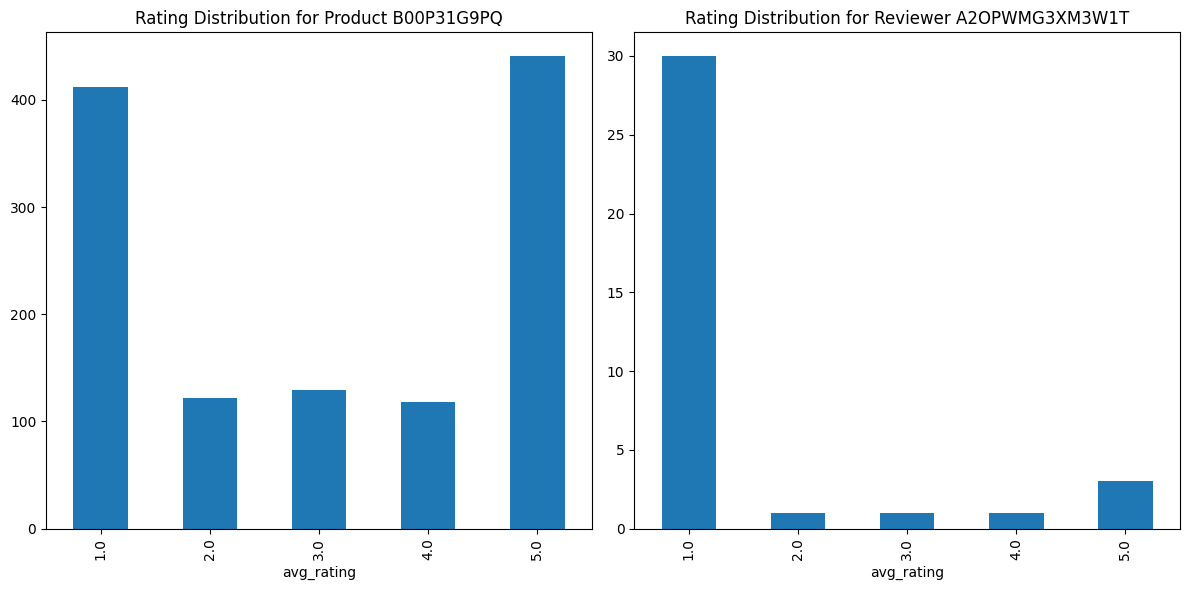

In [57]:
from textwrap import wrap

# Predict the ratings
df_enhance['prediction'] = df_enhance.apply(lambda x: predict_rating(x['reviewerID'], x['asin']), axis=1)
df_enhance['diff'] = round(df_enhance['avg_rating'] - df_enhance['prediction'],2) # show the difference between actual rating and predicted rating

most_decrease_reivew = df_enhance[['reviewerID', 'asin', 'reviewText', 'reviewText_clean_vader', 'vote', 'avg_rating', 'score_vader', 'score_vader_discrete', 'prediction', 'diff']].sort_values(by='diff', ascending=False).iloc[0]
print(f"*** review with lower adjusted rating:\n{most_decrease_reivew.T}")

# the review is 'Awesome', a very positive value, it seems original rating is fine
print(f"\nReview text: \n")
for line in wrap(most_decrease_reivew['reviewText'], width=70):
  print(line)

print('\n')

# plot the graphs
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 50% of the ratings are Fives
# 25% of the ratings are Ones
# It makes sense to reduce the rating as 25% of the ratings are Ones
df_enhance[df_enhance['asin']=='B00P31G9PQ'].avg_rating\
.value_counts().sort_index()\
.plot(kind='bar', ax=ax1, title='Rating Distribution for Product B00P31G9PQ')

# Most of the ratings give by this reviewer is One, 21 out of 26 are Ones, only two ratings are Five
# It makes sense to reduce the rating as Five seens to be outlier
df_enhance[df_enhance['reviewerID']=='A2OPWMG3XM3W1T'].avg_rating\
.value_counts().sort_index()\
.plot(kind='bar', ax=ax2, title='Rating Distribution for Reviewer A2OPWMG3XM3W1T')

plt.tight_layout()
plt.show()



In [58]:
df_enhance[df_enhance['reviewerID']=='ABOTQXNUBA1MM'].avg_rating\
.value_counts()

avg_rating
5.0    9
1.0    3
4.0    1
Name: count, dtype: int64


*** review with higher adjusted rating:
reviewerID                                                    ASKCZ1FA8Y20I
asin                                                             B000001A3A
reviewText                Seems like a nice idea in so many ways. Sad th...
reviewText_clean_vader    Not Mac compatible Too bad Seems like nice ide...
vote                                                                      0
avg_rating                                                              1.0
score_vader                                                          0.2815
score_vader_discrete                                                    4.0
prediction                                                         4.887528
diff                                                                  -3.89
Name: 366972, dtype: object

Review text: 

Seems like a nice idea in so many ways. Sad that it won't work on a
Mac.


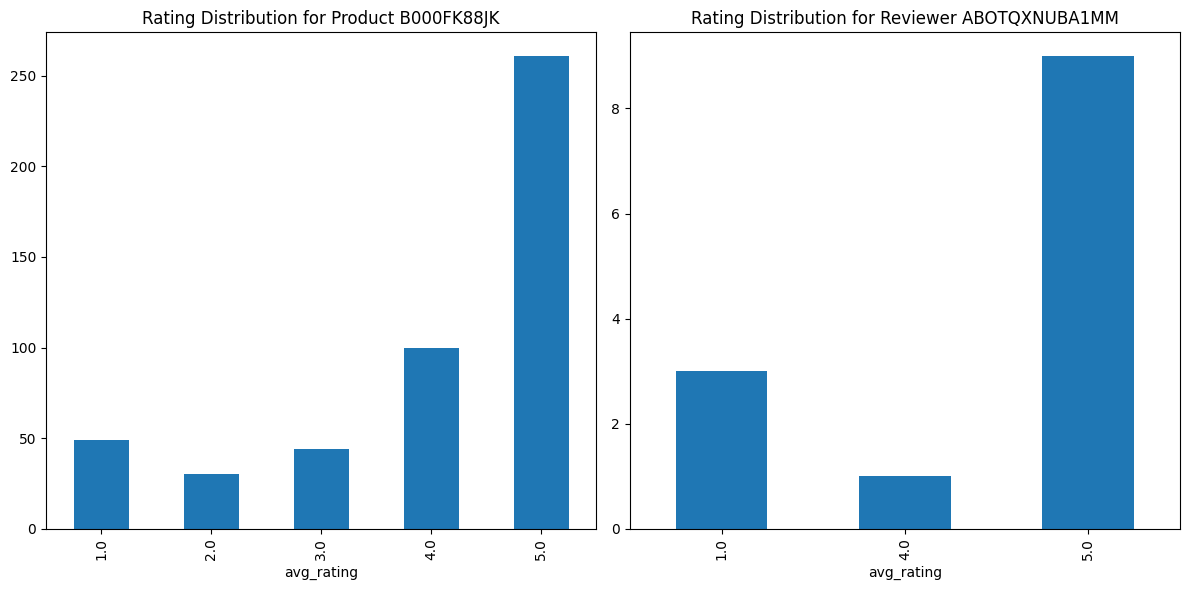

In [61]:

most_increase_reivew = df_enhance[['reviewerID', 'asin', 'reviewText', 'reviewText_clean_vader', 'vote', 'avg_rating', 'score_vader', 'score_vader_discrete', 'prediction', 'diff']].sort_values(by='diff', ascending=True).iloc[0]
print(f"\n*** review with higher adjusted rating:\n{most_increase_reivew.T}")


# the review is not very negative, the rating does not align with the review
print(f"\nReview text: \n")
for line in wrap(most_increase_reivew['reviewText'], width=70):
  print(line)

# plot the graphs
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# 64% of the ratings are Fives (16/25)
# 12% of the ratings are Ones (3/25)
# It makes sense to increase the rating as 64% of the ratings are Fives
df_enhance[df_enhance['asin']=='B000FK88JK'].avg_rating\
.value_counts().sort_index()\
.plot(kind='bar', ax=ax1, title='Rating Distribution for Product B000FK88JK')

# Most of the ratings give by this reviewer is Five, 9 out of 12 are Fives, only this rating is One
df_enhance[df_enhance['reviewerID']=='ABOTQXNUBA1MM'].avg_rating\
.value_counts().sort_index()\
.plot(kind='bar', ax=ax2, title='Rating Distribution for Reviewer ABOTQXNUBA1MM')

plt.tight_layout()
plt.show()



# 3.5 Text Summary (local)

In [62]:
from transformers import pipeline, set_seed

set_seed(42)

t5_summarizer = pipeline("summarization", model="t5-small", tokenizer="t5-small")
gpt2_generator = pipeline("text-generation", model="gpt2", tokenizer="gpt2", pad_token_id=50256, eos_token_id=50256)

df_summarize = df_processed[df_processed['reviewText'].apply(lambda x: 100 < len(str(x).split()) < 400)].iloc[:10].reset_index()

# summerize first 10 records
for i, row in df_summarize.iterrows():
    print(f"Review {i+1}:\n")
    for line in wrap(row['reviewText'], width=70):
        print(line)

    print(f"Summary {i+1}:\n")

    print("T5 Summarizer:")
    for line in wrap(t5_summarizer(row['reviewText'], max_length=50, truncation=True)[0]['summary_text'], width=70):
        print(line)

    print("\nGPT2 Summarizer:")
    # by adding TL;DR, we can generate a summary of the review
    for line in wrap(gpt2_generator(row['reviewText'] + " TL;DR", max_new_tokens=50)[0]['generated_text'], width=70):
        print(line)

    print("\n")


"""
Review 1:

I have used LearnSmart and can officially say that this is an amazing
study tool that quickly and simply adapts to your style of learning.
You can access it at anytime and it is on the go! Once you start using
LearnSmart you will quickly realize that this is the best way to learn
and study.  I am a business student and I did not use LearnSmart for
my Accounting I class, however, I did use it for my Accounting II
class. The grade difference from Accounting I to Accounting II was a
whole letter grade... thanks to LearnSmart!  Every college student
should definitely check it out!
Summary 1:

T5 Summarizer:
learnSmart is an amazing study tool that quickly and simply adapts to
your style of learning . you can access it at anytime and it is on the
go .

GPT2 Summarizer:
I have used LearnSmart and can officially say that this is an amazing
study tool that quickly and simply adapts to your style of learning.
You can access it at anytime and it is on the go! Once you start using
LearnSmart you will quickly realize that this is the best way to learn
and study.  I am a business student and I did not use LearnSmart for
my Accounting I class, however, I did use it for my Accounting II
class. The grade difference from Accounting I to Accounting II was a
whole letter grade... thanks to LearnSmart!  Every college student
should definitely check it out! TL;DR: learn smart  When we first
started learning for our classes on August 20, 2015 it was my top
favourite book I had ever read, but that was just prior to my first
class started on August 14 and I was still in the middle of


Review 2:

Maybe it's just me (I have no marketing background but desperately
want to learn for my start-up) but I cannot get hardly anything out of
this text. I have tried very hard to tread through the writing and
learn something useful but chapter after chapter seems to be the exact
same thing... overly wordy, rambling & unnecessarily academic writing
with no comprehensible message behind it, no strategies I can apply to
my own business and no organization that I can make sense of. Feels
almost like I'm reading a paper a college student BSed their way
through with a whole bunch of long words and cryptic sentences in
order to sound impressive. What a rip-off. I paid $70 for this and it
has been the most useless book I've paid for in my research process
(and I've read 16 other books thus far to help me with my venture).
The only reason I'm giving this two stars and not one star is that out
of the first six chapters I've read, two of them actually made sense.
One was on International Marketing and did a very good job explaining
the technology limitations of other countries and the ways foreign
citizens adapt to this and use technology. This is actually very
helpful information and I'm going to use it. The second was on the
legal and ethical aspects of using the internet. It gave an extremely
concise explanation with lots of info and it was easily
understandable. Unfortunately, I've read a chapter like this over and
over and over again in pretty much every e-business book I've picked
up so far so it's getting old.
Summary 2:

T5 Summarizer:
the only reason I'm giving this two stars is that out of the first six
chapters I've read, two of them actually made sense . one was on
international marketing and did a very good job explaining the
technology limitations of other

GPT2 Summarizer:
Maybe it's just me (I have no marketing background but desperately
want to learn for my start-up) but I cannot get hardly anything out of
this text. I have tried very hard to tread through the writing and
learn something useful but chapter after chapter seems to be the exact
same thing... overly wordy, rambling & unnecessarily academic writing
with no comprehensible message behind it, no strategies I can apply to
my own business and no organization that I can make sense of. Feels
almost like I'm reading a paper a college student BSed their way
through with a whole bunch of long words and cryptic sentences in
order to sound impressive. What a rip-off. I paid $70 for this and it
has been the most useless book I've paid for in my research process
(and I've read 16 other books thus far to help me with my venture).
The only reason I'm giving this two stars and not one star is that out
of the first six chapters I've read, two of them actually made sense.
One was on International Marketing and did a very good job explaining
the technology limitations of other countries and the ways foreign
citizens adapt to this and use technology. This is actually very
helpful information and I'm going to use it. The second was on the
legal and ethical aspects of using the internet. It gave an extremely
concise explanation with lots of info and it was easily
understandable. Unfortunately, I've read a chapter like this over and
over and over again in pretty much every e-business book I've picked
up so far so it's getting old. TL;DR - don't give this a bad review (I
love books written by foreigners in foreign countries, and it gives me
an excellent basis to work on my own business) and only try to write
stuff about it. And be fair and I'm not a
"""





Review 1:

I have used LearnSmart and can officially say that this is an amazing
study tool that quickly and simply adapts to your style of learning.
You can access it at anytime and it is on the go! Once you start using
LearnSmart you will quickly realize that this is the best way to learn
and study.  I am a business student and I did not use LearnSmart for
my Accounting I class, however, I did use it for my Accounting II
class. The grade difference from Accounting I to Accounting II was a
whole letter grade... thanks to LearnSmart!  Every college student
should definitely check it out!
Summary 1:

T5 Summarizer:
learnSmart is an amazing study tool that quickly and simply adapts to
your style of learning . you can access it at anytime and it is on the
go .

GPT2 Summarizer:
I have used LearnSmart and can officially say that this is an amazing
study tool that quickly and simply adapts to your style of learning.
You can access it at anytime and it is on the go! Once you start using
L

"\nReview 1:\n\nI have used LearnSmart and can officially say that this is an amazing\nstudy tool that quickly and simply adapts to your style of learning.\nYou can access it at anytime and it is on the go! Once you start using\nLearnSmart you will quickly realize that this is the best way to learn\nand study.  I am a business student and I did not use LearnSmart for\nmy Accounting I class, however, I did use it for my Accounting II\nclass. The grade difference from Accounting I to Accounting II was a\nwhole letter grade... thanks to LearnSmart!  Every college student\nshould definitely check it out!\nSummary 1:\n\nT5 Summarizer:\nlearnSmart is an amazing study tool that quickly and simply adapts to\nyour style of learning . you can access it at anytime and it is on the\ngo .\n\nGPT2 Summarizer:\nI have used LearnSmart and can officially say that this is an amazing\nstudy tool that quickly and simply adapts to your style of learning.\nYou can access it at anytime and it is on the go! O

# 3.6 Text Generation (local)

In [63]:
from transformers import pipeline

# Generate response
df_generate = df_processed[(df_processed['reviewText'].apply(lambda x:len(str(x).split()) < 100)) & (df_processed['reviewText'].str[-1]=="?")].iloc[:10].reset_index()

# summerize first 10 records
for i, row in df_generate.iterrows():
    print(f"Review {i+1}:\n")
    for line in wrap(row['reviewText'], width=70):
        print(line)

    print(f"Response {i+1}:\n")

    print("\nGPT2 Response:")
    # by adding TL;DR, we can generate a summary of the review
    for line in wrap(gpt2_generator(row['reviewText'], max_new_tokens=50)[0]['generated_text'], width=70):
        print(line)

    print("\n")

"""
Review 1:

I've had some issues with the download of this product. I had to do it
several times it recognized my product key, but the actual program
would not save for ease of use to my desktop.  I haven't needed office
in quite sometimes, and I am not one that will read through
instructions, maybe the new way of office is web based?
Response 1:


GPT2 Response:
I've had some issues with the download of this product. I had to do it
several times it recognized my product key, but the actual program
would not save for ease of use to my desktop.  I haven't needed office
in quite sometimes, and I am not one that will read through
instructions, maybe the new way of office is web based? My first
thought though though was to see how this solution can be done in
action. All I can say is that it is a solid option considering I'm a
computer nerd like myself for the past 5 years.   As if this wasn't
enough


"""


Review 1:

I've had some issues with the download of this product. I had to do it
several times it recognized my product key, but the actual program
would not save for ease of use to my desktop.  I haven't needed office
in quite sometimes, and I am not one that will read through
instructions, maybe the new way of office is web based?
Response 1:


GPT2 Response:
I've had some issues with the download of this product. I had to do it
several times it recognized my product key, but the actual program
would not save for ease of use to my desktop.  I haven't needed office
in quite sometimes, and I am not one that will read through
instructions, maybe the new way of office is web based? I had problems
with the software that worked but it was not easy to do when I just
clicked on download link.  The file doesn't work. Does this mean this
is 100% work and it isn't a bug? I'm not sure


Review 2:

After discovering how much MS wanted for a single slimy installation
of Office 2016 (my preferred 

"\nReview 1:\n\nI've had some issues with the download of this product. I had to do it\nseveral times it recognized my product key, but the actual program\nwould not save for ease of use to my desktop.  I haven't needed office\nin quite sometimes, and I am not one that will read through\ninstructions, maybe the new way of office is web based?\nResponse 1:\n\n\nGPT2 Response:\nI've had some issues with the download of this product. I had to do it\nseveral times it recognized my product key, but the actual program\nwould not save for ease of use to my desktop.  I haven't needed office\nin quite sometimes, and I am not one that will read through\ninstructions, maybe the new way of office is web based? My first\nthought though though was to see how this solution can be done in\naction. All I can say is that it is a solid option considering I'm a\ncomputer nerd like myself for the past 5 years.   As if this wasn't\nenough\n\n\n"

In [64]:
# testing on customized text
sample_text = "How to install windows?"
for line in wrap(gpt2_generator(sample_text, max_new_tokens=50)[0]['generated_text'], width=70):
    print(line)

"""
How to install windows? Find out how in the next step »  When
upgrading you need to follow these steps: • install an installer from
source (e.g. from a download on the PC),  • make sure you include
version check for newer versions (
"""

How to install windows?  Install Windows on a regular system. Windows
is a Windows XP or Windows Vista operating system.  Step 1: Change
permissions of Windows from "Administrator" to "root"  Set Windows
permissions on "root" by changing the


'\nHow to install windows? Find out how in the next step »  When\nupgrading you need to follow these steps: • install an installer from\nsource (e.g. from a download on the PC),  • make sure you include\nversion check for newer versions (\n'